In [1]:
import numpy as np
import operator
import matplotlib
import matplotlib.pyplot as plt
from time import sleep
from matplotlib.patches import Circle

In [2]:
# 查看测试数据，并给出一个 分割线，直观的理解一下 支持向量
def plotSVC(dataMat, labelMat, vetctors, weigth, b):
    xcord0 = []; ycord0 = []; xcord1 = []; ycord1 = []
    m, n = np.shape(dataMat)
    for i in range(m):
        if (labelMat[i] < 0):
            xcord0.append(dataMat[i][0])
            ycord0.append(dataMat[i][1])
        else:
            xcord1.append(dataMat[i][0])
            ycord1.append(dataMat[i][1])

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord0,ycord0, marker='s', s=90, label = '-1')
    ax.scatter(xcord1,ycord1, marker='o', s=50, c='red', label = '+1')
    plt.title('Support Vectors Circled')
    for i in range(len(vetctors)):
        circle = Circle(vetctors[i],0.5, facecolor='none', edgecolor=(0,0.8,0.8), linewidth=3, alpha=0.5)
        ax.add_patch(circle)

    #plt.plot([2.3,8.5], [-6,6]) #seperating hyperplane
    if(weigth[1] != 0):
        x = np.arange(-2.0, 12.0, 0.1)
        y = (-weigth[0]*x - b)/weigth[1]
        ax.plot(x,y)
    ax.axis([-2,12,-8,6])
    plt.legend(loc = 'upper left')
    plt.show()

In [3]:
def loadDataSet(fileName):
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = line.strip().split('\t')
        dataMat.append([float(lineArr[0]), float(lineArr[1])])
        labelMat.append(float(lineArr[2]))
    return dataMat,labelMat

In [4]:
dataMat,labelMat = loadDataSet('testSet.txt')

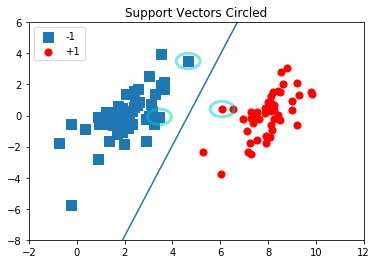

In [5]:
plotSVC(dataMat,labelMat,\
       [[4.6581910000000004, 3.507396],[3.4570959999999999, -0.082215999999999997], \
        [6.0805730000000002, 0.41888599999999998]], \
       [0.8065, -0.2761], -3.75567)

In [6]:
def selectJrand(i,m):
    j=i #we want to select any J not equal to i
    while (j==i):
        j = int(np.random.uniform(0,m))
    return j

In [7]:
# 约束 aj 必须在 L H之间
def clipAlpha(aj,H,L):
    if aj > H: 
        aj = H
    if L > aj:
        aj = L
    return aj

In [8]:
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    dataMatrix = np.mat(dataMatIn); labelMat = np.mat(classLabels).transpose()
    b = 0; m,n = np.shape(dataMatrix)
    alphas = np.mat(np.zeros((m,1)))
    iterNum = 0
    while (iterNum < maxIter):
        alphaPairsChanged = 0
        for i in range(m):
            # 周志华 公式 6.12
            fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
            Ei = fXi - float(labelMat[i])#if checks if an example violates KKT conditions
            # (alphas[i] < C) (alphas[i] > 0) 这两个条件应该式 恒 true的
            if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) \
                    or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
                j = selectJrand(i,m)
                fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
                Ej = fXj - float(labelMat[j])
                alphaIold = alphas[i].copy(); 
                alphaJold = alphas[j].copy();
                if (labelMat[i] != labelMat[j]):
                    L = max(0, alphas[j] - alphas[i])
                    H = min(C, C + alphas[j] - alphas[i])
                else:
                    L = max(0, alphas[j] + alphas[i] - C)
                    H = min(C, alphas[j] + alphas[i])
                if L==H: 
                    # print("L==H"); 
                    continue
                # 向量之间的距离 （取得负值）    
                eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T \
                            - dataMatrix[j,:]*dataMatrix[j,:].T
                if eta >= 0:
                    # print("eta>=0"); 
                    continue
                alphas[j] -= labelMat[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j],H,L)
                if (abs(alphas[j] - alphaJold) < 0.00001): 
                    #print("j not moving enough");
                    continue
                #约束条件 6.10     
                alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
                #update i by the same amount as j
                #the update is in the oppostie direction
                # 公式 6.18    
                b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T \
                            - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
                b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T \
                        - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
                if (0 < alphas[i]) and (C > alphas[i]): b = b1
                elif (0 < alphas[j]) and (C > alphas[j]): b = b2
                else: b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                # print ("iter: %d i:%d, \t %.6f  %.6f \tchanged %d" % (iterNum,i, alphas[i], alphas[j], alphaPairsChanged))
        if (alphaPairsChanged == 0): iterNum += 1
        else: iterNum = 0
        #print ("iteration number: %d" % iterNum)
    return b,alphas

In [9]:
b, alphas = smoSimple(dataMat,labelMat, 0.6, 0.001, 50)

In [10]:
alphas[alphas>0].tolist()[0]

[0.10194675179423147,
 0.2644795824673563,
 0.03271601005479203,
 0.33371032420679575]

In [11]:
b

matrix([[-3.82843951]])

In [12]:
def calcWs(alphas,dataArr,classLabels):
    X = np.mat(dataArr); 
    labelMat = np.mat(classLabels).transpose()
    m,n = np.shape(X)
    w = np.zeros((n,1))
    vetctors = []
    for i in range(m):
        #w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
        if(alphas[i]>0.0):
            w += np.multiply(alphas[i]*labelMat[i],X[i,:].T)
            vetctors.append(dataArr[i])
    return w, vetctors

In [13]:
w, vetctors = calcWs(alphas,dataMat,labelMat)
vetctors

[[4.658191, 3.507396],
 [3.457096, -0.082216],
 [5.286862, -2.358286],
 [6.080573, 0.418886]]

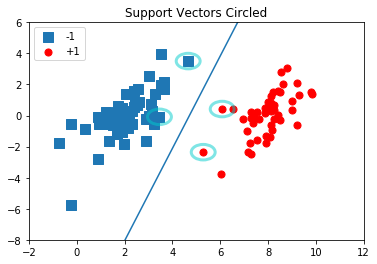

In [14]:
plotSVC(dataMat,labelMat,vetctors,w, b.tolist()[0][0] )

In [15]:
# 核函数，通告增加维数 来找到可以分类 的超平面
def kernelTrans(X, A, kTup): 
    #calc the kernel or transform data to a higher dimensional space
    m,n = np.shape(X)
    K = np.mat(np.zeros((m,1)))
    if kTup[0]=='lin': K = X * A.T   #linear kernel
    elif kTup[0]=='rbf':
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow*deltaRow.T
        K = np.exp(K/(-1*kTup[1]**2)) 
        #divide in NumPy is element-wise not matrix like Matlab
    else: raise NameError('Houston We Have a Problem -- \
    That Kernel is not recognized')
    return K

In [16]:
class optStruct:
    # Initialize the structure with the parameters 
    def __init__(self,dataMatIn, classLabels, C, toler, kTup):          
        self.X = dataMatIn
        self.labelMat = classLabels
        self.C = C
        self.tol = toler
        self.m = np.shape(dataMatIn)[0]
        self.alphas = np.mat(np.zeros((self.m,1)))
        self.b = 0
        self.eCache = np.mat(np.zeros((self.m,2))) #first column is valid flag
        self.K = np.mat(np.zeros((self.m,self.m)))
        for i in range(self.m):
            self.K[:,i] = kernelTrans(self.X, self.X[i,:], kTup)

In [17]:
def calcEk(oS, k):
    fXk = float(np.multiply(oS.alphas,oS.labelMat).T * oS.K[:,k] + oS.b)
    # 没有 核函数的 误差计算方式
    #fXk = float(np.multiply(oS.alphas, oS.labelMat).T*(oS.X*oS.X[k,:].T) + oS.b)
    Ek = fXk - float(oS.labelMat[k])
    return Ek

In [18]:
def selectJ(i, oS, Ei):         #this is the second choice -heurstic, and calcs Ej
    maxK = -1; maxDeltaE = 0; Ej = 0
    oS.eCache[i] = [1,Ei]  #set valid #choose the alpha that gives the maximum delta E
    validEcacheList = np.nonzero(oS.eCache[:,0].A)[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:   #loop through valid Ecache values and find the one that maximizes delta E
            if k == i: continue #don't calc for i, waste of time
            Ek = calcEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k; maxDeltaE = deltaE; Ej = Ek
        return maxK, Ej
    else:   #in this case (first time around) we don't have any valid eCache values
        j = selectJrand(i, oS.m)
        Ej = calcEk(oS, j)
    return j, Ej

In [19]:
def updateEk(oS, k):#after any alpha has changed update the new value in the cache
    Ek = calcEk(oS, k)
    oS.eCache[k] = [1,Ek]

In [20]:
def innerL(i, oS):
    Ei = calcEk(oS, i)
    if ((oS.labelMat[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) \
            or ((oS.labelMat[i]*Ei > oS.tol) and (oS.alphas[i] > 0)):
        
        j,Ej = selectJ(i, oS, Ei) #this has been changed from selectJrand
        alphaIold = oS.alphas[i].copy(); alphaJold = oS.alphas[j].copy();
        if (oS.labelMat[i] != oS.labelMat[j]):
            L = max(0, oS.alphas[j] - oS.alphas[i])
            H = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            L = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            H = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if L==H: 
            #print("L==H");
            return 0
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j] #changed for kernel
        if eta >= 0: 
            #print("eta>=0");
            return 0
        oS.alphas[j] -= oS.labelMat[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j],H,L)
        updateEk(oS, j) #added this for the Ecache
        if (abs(oS.alphas[j] - alphaJold) < 0.00001): 
            #print ("j not moving enough");
            return 0
        #update i by the same amount as j
        oS.alphas[i] += oS.labelMat[j]*oS.labelMat[i]*(alphaJold - oS.alphas[j])        
        updateEk(oS, i) #added this for the Ecache                    
        #the update is in the oppostie direction
        b1 = oS.b - Ei- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,i] \
                  - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[i,j]
        b2 = oS.b - Ej- oS.labelMat[i]*(oS.alphas[i]-alphaIold)*oS.K[i,j] \
                  - oS.labelMat[j]*(oS.alphas[j]-alphaJold)*oS.K[j,j]
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[i]): oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]): oS.b = b2
        else: oS.b = (b1 + b2)/2.0
        return 1
    else: return 0

In [21]:
def smoP(dataMatIn, classLabels, C, toler, maxIter,kTup=('lin', 0)):    #full Platt SMO
    oS = optStruct(np.mat(dataMatIn),np.mat(classLabels).transpose(),C,toler, kTup)
    iterNum = 0
    entireSet = True; alphaPairsChanged = 0
    while (iterNum < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:   #go over all
            for i in range(oS.m):        
                alphaPairsChanged += innerL(i,oS)
                #print ("fullSet, iter: %d i:%d, pairs changed %d" % (iterNum,i,alphaPairsChanged))
            iterNum += 1
        else:#go over non-bound (railed) alphas
            nonBoundIs = np.nonzero((oS.alphas.A > 0) * (oS.alphas.A < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerL(i,oS)
                # print ("non-bound, iter: %d i:%d, pairs changed %d" % (iterNum,i,alphaPairsChanged))
            iterNum += 1
        if entireSet: 
            entireSet = False #toggle entire set loop
        elif (alphaPairsChanged == 0):
            entireSet = True  
        #print ("iteration number: %d" % iterNum)
    return oS.b,oS.alphas

In [22]:
b, alphas = smoP(dataMat,labelMat,0.6, 0.0001, 50)

In [23]:
w, vetctors = calcWs(alphas,dataMat,labelMat)
vetctors

[[3.542485, 1.977398],
 [2.114999, -0.004466],
 [8.127113, 1.274372],
 [4.658191, 3.507396],
 [8.197181, 1.545132],
 [7.40786, -0.121961],
 [6.960661, -0.245353],
 [6.080573, 0.418886],
 [3.107511, 0.758367]]

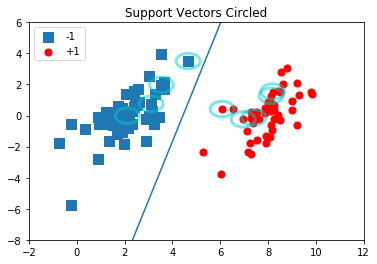

In [24]:
plotSVC(dataMat,labelMat,vetctors,w , b.tolist()[0][0])

In [25]:
dataMat[2]*np.mat(w) + b

matrix([[2.30436336]])

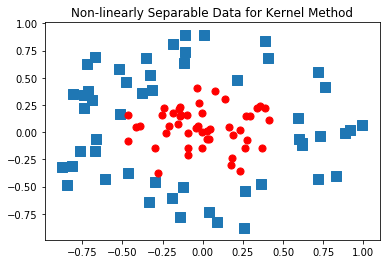

In [26]:
# 生成测试数据
fw = open('testSetRBF3.txt', 'w')#generate data
fig = plt.figure()
ax = fig.add_subplot(111)
xcord0 = []; ycord0 = []; xcord1 = []; ycord1 = []
for i in range(100):
    [x,y] = np.random.uniform(0,1,2)
    xpt=x*np.cos(2.0*np.pi*y); ypt = x*np.sin(2.0*np.pi*y)
    #xpt = (xpt+1)*7 - 2 
    #ypt = (ypt+1)*7 - 8
    if (x > 0.5):
        xcord0.append(xpt); ycord0.append(ypt)
        label = -1.0
    else:
        xcord1.append(xpt); ycord1.append(ypt)
        label = 1.0
    fw.write('%f\t%f\t%f\n' % (xpt, ypt, label))
ax.scatter(xcord0,ycord0, marker='s', s=90)
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red')
plt.title('Non-linearly Separable Data for Kernel Method')
plt.show()
fw.close()


In [27]:
def testRbf(C, toler, maxIter, kTup =('rbf', 1.3)):
    dataArr,labelArr = loadDataSet('testSetRBF.txt')
    b,alphas = smoP(dataArr, labelArr,C, toler, maxIter,kTup) #C=200 important
    datMat= np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    svInd=np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] #get matrix of only support vectors
    labelSV = labelMat[svInd];
    print ("there are %d Support Vectors" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!= np.sign(labelArr[i]): 
            errorCount += 1
    print ("the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadDataSet('testSetRBF2.txt')
    errorCount = 0
    datMat=np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): errorCount += 1    
    print ("the test error rate is: %f" % (float(errorCount)/m))
    return dataArr,labelArr, b,alphas 

In [28]:
dataArr,labelArr , b, alphas = testRbf(200, 0.0001, 10000,('rbf', 1.5))

there are 33 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.070000


In [29]:
w, vetctors = calcWs(alphas, dataArr, labelArr)

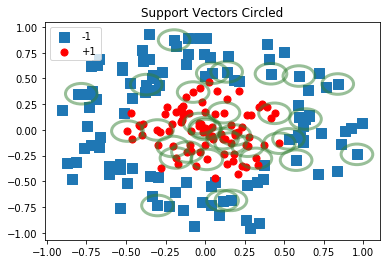

In [30]:
m, n = np.shape(dataArr)
for i in range(m):
    if (labelArr[i] < 0):
        xcord0.append(dataArr[i][0])
        ycord0.append(dataArr[i][1])
    else:
        xcord1.append(dataArr[i][0])
        ycord1.append(dataArr[i][1])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xcord0,ycord0, marker='s', s=90, label = '-1')
ax.scatter(xcord1,ycord1, marker='o', s=50, c='red', label = '+1')
plt.title('Support Vectors Circled')
for i in range(len(vetctors)):
    circle = Circle(vetctors[i],0.1, facecolor='none', edgecolor=(0.2,0.5,0.2), linewidth=3, alpha=0.5)
    ax.add_patch(circle)

plt.legend(loc = 'upper left')
plt.show()

In [31]:
def img2vector(filename):
    returnVect = np.zeros((1,1024))
    fr = open(filename)
    for i in range(32):
        lineStr = fr.readline()
        for j in range(32):
            returnVect[0,32*i+j] = int(lineStr[j])
    return returnVect

In [32]:
# 借用第二章测测试用例
def loadImages(dirName):
    from os import listdir
    hwLabels = []
    trainingFileList = listdir(dirName)           #load the training set
    m = len(trainingFileList)
   
    caseCount = 0
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9 or classNumStr == 1: 
            caseCount +=1

    trainingMat = np.zeros((caseCount,1024))
    caseCount = 0
    for i in range(m):
        fileNameStr = trainingFileList[i]
        fileStr = fileNameStr.split('.')[0]     #take off .txt
        classNumStr = int(fileStr.split('_')[0])
        if classNumStr == 9: 
            hwLabels.append(-1)
            trainingMat[caseCount,:] = img2vector('%s/%s' % (dirName, fileNameStr))
            caseCount +=1
        elif classNumStr == 1: 
            hwLabels.append(1)
            trainingMat[caseCount,:] = img2vector('%s/%s' % (dirName, fileNameStr))
            caseCount +=1
            
    return trainingMat, hwLabels    


In [33]:
def testDigits(kTup=('rbf', 10)):
    dataArr,labelArr = loadImages('../ch02/trainingDigits')
    b,alphas = smoP(dataArr, labelArr, 200, 0.0001, 10000, kTup)
    datMat= np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    svInd= np.nonzero(alphas.A>0)[0]
    sVs=datMat[svInd] 
    labelSV = labelMat[svInd];
    print ("there are %d Support Vectors" % np.shape(sVs)[0])
    m,n = np.shape(datMat)
    errorCount = 0
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): errorCount += 1
    print ("the training error rate is: %f" % (float(errorCount)/m))
    dataArr,labelArr = loadImages('../ch02/testDigits')
    errorCount = 0
    datMat= np.mat(dataArr); labelMat = np.mat(labelArr).transpose()
    m,n = np.shape(datMat)
    for i in range(m):
        kernelEval = kernelTrans(sVs,datMat[i,:],kTup)
        predict=kernelEval.T * np.multiply(labelSV,alphas[svInd]) + b
        if np.sign(predict)!=np.sign(labelArr[i]): errorCount += 1    
    print ("the test error rate is: %f" % (float(errorCount)/m)) 

In [34]:
testDigits(('lin', 10))

there are 38 Support Vectors
the training error rate is: 0.049751
the test error rate is: 0.043011


In [35]:
testDigits(('rbf', 10))

there are 147 Support Vectors
the training error rate is: 0.000000
the test error rate is: 0.010753
